In [1]:
%load_ext sql

In [2]:
%sql sqlite:///C:/sqlite/chinook2.db

# 1) Introduction to Correlated Subqueries

There are three types of subqueries we're working with in this course.

Subqueries as values that yield only a **single value**

Subqueries as lists that yield several rows but only a **single column**

Subqueries as tables that yield **several rows and several columns**

Now we'll focus on correlated and nested subqueries.

A **correlated subquery** is an inner query that uses values from the outer query. As a result, it can't execute independently like other subqueries.

Let's run the following query to find the **average sale per customer**.

In [8]:
%%sql
SELECT last_name, 
       first_name, 
       (SELECT AVG(total)
          FROM invoice i
         WHERE c.customer_id = i.customer_id) total_avg
  FROM customer c
  Limit 5;

 * sqlite:///C:/sqlite/chinook2.db
Done.


last_name,first_name,total_avg
Gonçalves,Luís,8.376923076923076
Köhler,Leonie,7.47
Tremblay,François,11.11
Hansen,Bjørn,8.03
Wichterlová,František,8.03


# 2) Filtering with Correlated Subqueries

The query contains a correlated subquery because the `WHERE` definition depends on the outer query. We can't run the subquery separately.

```sql
SELECT name, 
       (SELECT AVG(total)
          FROM invoice_line AS il
         WHERE f.id = il.fruit_id) AS total_avg
  FROM fruit AS f;
```

We can also use a **multi-column subquery** with joins to get the same result as the query above. The following example calculates the average total of all invoices for each customer.

```sql
SELECT last_name,  first_name,  total_avg
  FROM customer c
  JOIN (SELECT customer_id, AVG(total) AS total_avg
          FROM invoice
         GROUP BY customer_id) i
    ON c.customer_id = i.customer_id;
```

However, there are cases when the use of correlated subqueries is more appropriate than joins — for example, when inner and outer queries operate on the same table. Let's illustrate it with this exercise where we use a correlated subquery in the `WHERE` clause.

## Instructions

1. Write a query to display all invoices where the total purchase amount (`total`) is greater than the **average purchase** amount in **the same country**.

1. Make sure to at least select the `invoice_id` column.

In [10]:
%%sql
SELECT i1.invoice_id, i1.billing_country, i1.total
FROM invoice i1
WHERE i1.total > (SELECT AVG(total) 
         FROM invoice as i2
        WHERE i1.billing_country = i2.billing_country )
limit 5;

 * sqlite:///C:/sqlite/chinook2.db
Done.


invoice_id,billing_country,total
1,USA,15.84
2,Canada,9.9
5,USA,16.83
7,Poland,10.89
8,India,9.9


# 3) EXISTS Operators

We often use correlated subqueries with the EXISTS operator. EXISTS is a logical operator that checks if the subquery returns any row. The syntax of its use is as follows:

```sql
SELECT column_1, column_2, . . .
  FROM table
 WHERE EXISTS(subquery);
 ```

For example, we can find the list of customers that purchased something:

In [12]:
%%sql
SELECT first_name, last_name
  FROM customer c
 WHERE EXISTS(SELECT *
                FROM invoice i
               WHERE c.customer_id = i.customer_id)
 Limit 5;

 * sqlite:///C:/sqlite/chinook2.db
Done.


first_name,last_name
Luís,Gonçalves
Leonie,Köhler
François,Tremblay
Bjørn,Hansen
František,Wichterlová


We can also negate the `EXISTS` operator with `NOT EXISTS` to find the list of customers that **didn't purchase anything**.

This yields an empty table showing that all customers purchased at least something.

In [13]:
%%sql
SELECT first_name, last_name
  FROM customer c
 WHERE NOT EXISTS(SELECT *
                FROM invoice i
               WHERE c.customer_id = i.customer_id);

 * sqlite:///C:/sqlite/chinook2.db
Done.


first_name,last_name


## Instructions

1. Write a query to display all tracks that have **never been sold**. Use the `NOT EXISTS` operator and a correlated subquery.

* Here are the `invoice_line` and `track` tables and how they are linked to help you with this problem.

* Make sure to at least select the `track_id` column.

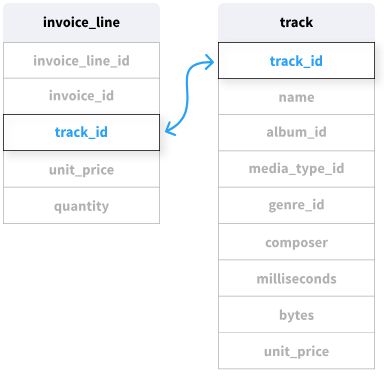

In [14]:
%%sql
SELECT t.track_id, t.name, t.unit_price
  FROM track t
  WHERE NOT EXISTS(SELECT *
                   FROM invoice_line i
                   WHERE t.track_id = i.track_id)
  Limit 5;

 * sqlite:///C:/sqlite/chinook2.db
Done.


track_id,name,unit_price
99,Your Time Has Come,0.99
101,Be Yourself,0.99
104,Heaven's Dead,0.99
106,Man Or Animal,0.99
107,Yesterday To Tomorrow,0.99


# 4) Nested Subqueries

The information in a relational database like chinook is distributed in several tables that are linked together. We can combine this information in two different ways:

* Join tables of interest and then filter or extract the data we want

* Use subqueries to filter or extract the data we want

In general, when we have more than three tables, nested subqueries can be necessary to retrieve information. A nested subquery is a query nested inside another subquery. We can end up having several levels of nesting.

Suppose that we want to find the playlists that contain tracks whose duration is greater than or equal to `900000` milliseconds (15 minutes). To answer this question, we need three tables. We can write this query to answer the question using nested subqueries.

```sql
SELECT name
  FROM playlist
 WHERE playlist_id IN (SELECT playlist_id
                         FROM playlist_track
                        WHERE track_id IN (SELECT track_id
                                             FROM track
                                            WHERE milliseconds >= 900000));
```

> name -> playlist_id -> track_id -> track > 15 min

## Instructions

![alt text](chinook_schema.svg)

1. Write a query that uses nested subqueries to find employees by `last_name` and `first_name` involved in transactions where the customers' **total purchase** amount is **greater than one hundred dollars**.




In [15]:
%%sql
SELECT last_name, first_name
  FROM employee
 WHERE employee_id IN (SELECT support_rep_id
                         FROM customer
                        WHERE customer_id IN (SELECT customer_id
                                                FROM invoice
                                                GROUP BY customer_id 
                                              HAVING SUM(total) > 100))


 * sqlite:///C:/sqlite/chinook2.db
Done.


last_name,first_name
Peacock,Jane
Park,Margaret
Johnson,Steve


# 5) Putting it All Together

1. A subquery is a query nested inside another query.

1. The main rule when using subquery is to enclose it in parentheses.

1. There are three types of subqueries based on their output:

    * Scalar subqueries (single value). Use them anywhere you can use values — for example, operations and `WHERE` clauses.

    * Multi-row subqueries (several values, one column). Use them, for example, to filter rows with `IN` and `NOT IN` operators.

    * Multi-column subqueries (several rows, several columns). Use them wherever you can use tables (i.e., `FROM` and with joins).

1. A **correlated subquery** is a subquery that we **can't execute separately** from the outer query execution. A correlated subquery can be any type of subquery (scalar, multi-row, or multi-column).
    
1. A **nested subquery** is a subquery nested inside another subquery. We can nest any type of subquery (scalar, multi-row, or multi_column) inside another subquery.

1. Generally it's joined by `WHERE` clause `WHERE c.customer_id = i.customer_id) total_avg`

For all of these subqueries we follow the same style guidelines we use for queries.

# 6) Writing Effective Subqueries

how do we write effective queries?

For example, we want the list of invoices, their **total purchase amount** and the **total number of minutes** of **metal genre tracks** purchased in the **United States**. How do we write a query that solves this problem?

Writing a query to solve this problem can be quite tedious. Using subqueries to solve a problem is not straightforward, especially if you don't have a systematic approach to solving them. Here are some steps to follow to write effective queries:

1. Identify the tables where you can find the information you are looking for

1. Identify the sub-problems to solve

1. Write the queries to solve these sub-problems

1. See how to combine and modify these queries to reach a solution with a single query.

1. Optimize the query if necessary — there can be several approaches to solve the same problem.

For our example, looking at the **chinook database schema**, we can see that the `invoice`, `track`, and `genre` tables are necessary. However, to link these tables, we'll also need the `invoice_line` table.

Let's identify the sub-problems to solve and write the associated subqueries.

**1. Finding the `customer_id` whose `billing_country` is the United States:**

```sql
SELECT customer_id
  FROM invoice
 WHERE billing_country = 'USA';
```

**2. Finding the `genre_id` where name contains 'Metal':**

```sql
SELECT genre_id
  FROM genre
 WHERE name LIKE '%Metal%';
 ```

**3. Computing the total purchase amount and the total number of minutes of tracks:**

```sql
SUM(tr.quantity * tr.unit_price)

SUM(tr.milliseconds)/1000.0/60
```
**4. Joining information in `invoice_line` and `track` tables to have `unit_price`, `quantity`, and `milliseconds` in the same table:**

```sql
SELECT il.*, t.milliseconds, t.genre_id
  FROM invoice_line il
  JOIN track t
    ON il.track_id = t.track_id;
```

**5. Filtering the previous table where the billing_country is the United States:**

```sql
SELECT il.*, t.milliseconds, t.genre_id
  FROM invoice_line il
  JOIN track t
    ON il.track_id = t.track_id
 WHERE invoice_id IN (SELECT invoice_id 
                        FROM invoice
                       WHERE billing_country = 'USA');
```



## Instructions

![alt text](chinook_schema.svg)

1. Write a final query combining the examples in the Learn section in order to get the following result:

We want the list of invoices, their total purchase amount and the total number of minutes of any metal genre tracks purchased in the United States.

| invoice_id | total | minute   |
|------------|-------|----------|
| 4          | 1.98  | 8.788883 |
| 9          | 1.98  | 7.653433 |
| 17         | 1.98  | 9.959167 |
| 18         | 0.99  | 4.379850 |
| 42         | 0.99  | 3.415500 |

In [ ]:
%%sql
SELECT tr.invoice_id AS invoice_id, 
       SUM(tr.quantity * tr.unit_price) AS total, --calculate total per invoice
       SUM(tr.milliseconds)/1000.0/60 AS minute --calculate total minutes per invoice
  FROM (SELECT il.*, t.milliseconds, t.genre_id
          FROM invoice_line il
          JOIN track t
            ON il.track_id = t.track_id
         WHERE il.invoice_id IN (SELECT invoice_id 
                                FROM invoice 
                               WHERE billing_country = 'USA')) tr --filter only USA invoices
 WHERE tr.genre_id IN (SELECT genre_id 
                         FROM genre 
                        WHERE name LIKE '%Metal%') --filter only Metal genre
 GROUP BY tr.invoice_id
limit 5;

 * sqlite:///C:/sqlite/chinook2.db
Done.


invoice_id,total,minute
4,1.98,8.788883333333333
9,1.98,7.653433333333334
17,1.98,9.959166666666667
18,0.99,4.37985
42,0.99,3.4155
